# PART 4. END OF DISTRIBUTION IMPUTATION

It is an automation of arbitrary value imputation by selecting arbitrary values at the end of the variable distributions.

<br>

__Dtypes__:<br>
- numerical variables.

__Assumptions__:<br>
- MNAR - values are not missing at random.<br>
- the missing observations, most likely look like the majority of the observations in the variable.<br>
- a) normally distributed (the mean + or - 3 times the std); b) skewed (the IQR proximity rule)

__Limitations__:
- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset
- Distortion of true outliers in the distribution

__Datasets__:<br>
- House Prices dataset <br>
- Titanic dataset

<br>

### Content:

__I. Titanic Dataset__:
1. Loading Data and Basic Data Exploration
2. Imputation
    - Train/Test splitting.
    - Identifying missing values columns and an extreme value. Adding extreme value columns
    - Detection of changes before and after the imputation.
    
__II. House Prices Dataset Dataset__:
1. Loading Data and Basic Data Exploration
2. Imputation
    - Train/Test splitting.
    - Identifying missing values columns and an extreme value. Adding extreme value columns
    - Detection of changes before and after the imputation. 


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# I. Titanic

## 1. Loading Data and Basic Data Exploration

In [2]:
# load the Titanic Dataset with a few variables for analysing
# and further imputation exploring

data = pd.read_csv('../titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# the percentage of NA

data.isnull().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

The only variable with missing data is Age, with ~20% of missing observations.

## 2. Imputation

### - Train/Test splitting

Imputation should be done over the training set, and then propagated to the test set. For arbitrary value imputation, this is not so important, the value is chosen arbitrarily, however it is good to adhere to this practice and select the arbitrary value by looking only at the distribution of the variables in the train set.

In [4]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'], 
    test_size=0.3, 
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

### - Identifying missing values columns and an arbitrary extreme value. Adding replaced value columns

In [5]:
# a function to fill missing values with an extreme value:

def impute_na(df, variable, value):

    return df[variable].fillna(value)

<AxesSubplot:>

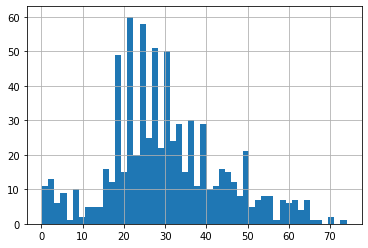

In [6]:
# the distribution of Ages
X_train.age.hist(bins=50)

In [7]:
# far end of the distribution:

# because Age looks approximately Gaussian, 
# use the mean and std to calculate the replacement value

X_train.age.mean() + 3 * X_train.age.std()

72.03416424092518

In [8]:
# dding replecing value column (with rounded replecing value)

X_train['Age_imputed'] = impute_na(X_train, 'age',
                                   round(X_train.age.mean() + 3 * X_train.age.std(), 3))

X_train.head(15)

,age,fare,Age_imputed
501,13.0,19.5000,13.000
588,4.0,23.0000,4.000
402,30.0,13.8583,30.000
1193,NaN,7.7250,72.034
686,22.0,7.7250,22.000
971,NaN,7.8792,72.034
117,30.0,56.9292,30.000
540,2.0,26.0000,2.000
294,49.0,110.8833,49.000
261,35.0,26.2875,35.000


### - Detection of changes before and after the imputation.

__A) a change in the distribution:__

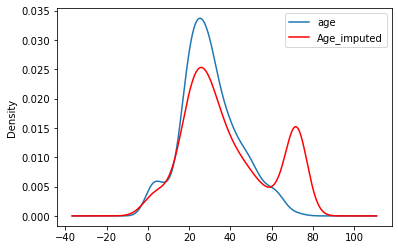

In [9]:
# expected: it has changed 
# with now more values accumulating towards the tail

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# imputed variable
X_train['Age_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

As mentioned above, similarly to arbitrary value imputation, the end of tail imputation distorts the original distribution of the variable Age. The transformed variable shows more values around the selected tail value.

_bad for_: linear models which assume that the variables are normally distributed. End of tail imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.


_good for_: tree-based algorithms.

__B) a change in the variance:__

In [10]:
# expected: quite a big changes  
# as the percentage of missing data is quite high in Age (~20%)

print('Original variable variance: ', X_train['age'].var())
print('Variance after 99 imputation: ', X_train['Age_imputed'].var())

Original variable variance:  194.16304666581854
Variance after 99 imputation:  427.3898592349109


__C) a change in the covariance:__

In [11]:
# end of tail imputation may affect the relationship 
# with the other variables in the dataset
X_train[['fare', 'age', 'Age_imputed']].cov()

,fare,age,Age_imputed
fare,2248.326729,136.176223,19.647495
age,136.176223,194.163047,194.163047
Age_imputed,19.647495,194.163047,427.389859


We see indeed that the covariance between Age and Fare is changed after the arbitrary value imputation.

__D) a change in the outlier amount:__

<AxesSubplot:>

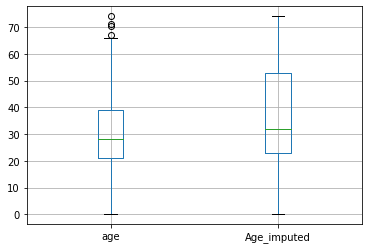

In [12]:
# that arbitrary value imputation may affect the perception of outliers

# find out using a boxplot
X_train[['age', 'Age_imputed']].boxplot()

It masks the outliers!!!

# II. House Prices Dataset

## 1. Loading Data and Basic Data Exploration

In [13]:
# use only the following variables (the best suitable columns)

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [14]:
# load the House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [15]:
# print the variables that contain missing data

[var for var in data.columns if data[var].isnull().sum()>0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [16]:
# find the percentage of missing data within those variables

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

## 2. Imputation

### - Train/Test splitting

In [17]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

### - Identifying missing values columns and an extreme value. Adding extreme value columns

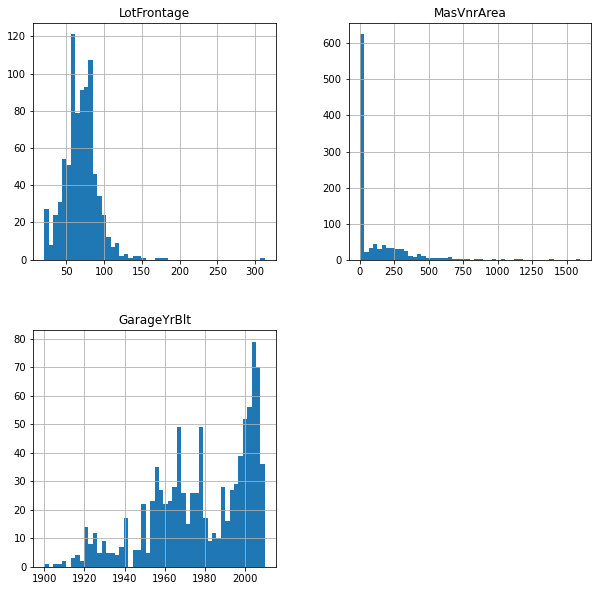

In [18]:
# explore the distribution of the variables
# to decide which extreme value to use

X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=50, figsize=(10,10))
plt.show()

In [19]:
# the variables are not normally distributed

# gonna impute the NA using the IQR proximity rule

In [20]:
# for LotFrontage:

# calulate the IQR
IQR = X_train['LotFrontage'].quantile(0.75) - X_train['LotFrontage'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['LotFrontage'].quantile(0.75) + 3 * IQR

extreme_value

146.0

In [21]:
# LotFrontage: impute the NA with the extreme value

X_train.loc[:,'LotFrontage_imputed'] = impute_na(X_train, 'LotFrontage', extreme_value)
X_test.loc[:,'LotFrontage_imputed'] = impute_na(X_test, 'LotFrontage', extreme_value)

C:\Users\48796\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\48796\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [22]:
# the same for MasVnrArea:

# calculate the IQR
IQR = X_train['MasVnrArea'].quantile(0.75) - X_train['MasVnrArea'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['MasVnrArea'].quantile(0.75) + 3 * IQR

extreme_value

680.0

In [23]:
# MasVnrArea: impute the NA with the extreme value

X_train.loc[:,'MasVnrArea_imputed'] = impute_na(X_train, 'MasVnrArea', extreme_value)
X_test.loc[:,'MasVnrArea_imputed'] = impute_na(X_test, 'MasVnrArea', extreme_value)

In [24]:
# the same for GarageYrBlt:

# calculate the IQR
IQR = X_train['GarageYrBlt'].quantile(0.75) - X_train['GarageYrBlt'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['GarageYrBlt'].quantile(0.75) + 3 * IQR

extreme_value

2121.0

In [25]:
# GarageYrBlt: impute the NA with the extreme value

X_train.loc[:,'GarageYrBlt_imputed'] = impute_na(X_train, 'GarageYrBlt', extreme_value)
X_test.loc[:,'GarageYrBlt_imputed'] = impute_na(X_test, 'GarageYrBlt', extreme_value)

### - Detection of changes before and after the imputation.

__A) a change in the distribution:__

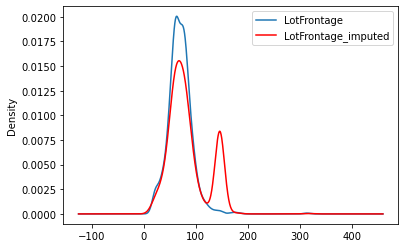

In [26]:
# for LotFrontAge: 

# expected: the distribution has changed
# with now more values accumulating towards the extreme value

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# imputed variable
X_train['LotFrontage_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

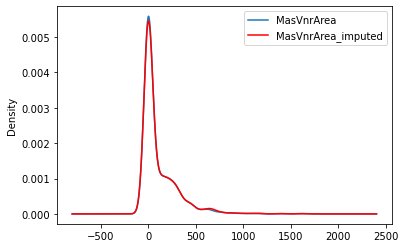

In [27]:
# for MasVnrArea: 

# expected: the distribution has tiny change, as
# MasVnrArea had only few outliers

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# imputed variable
X_train['MasVnrArea_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

From the above plots we can see that the distribution of LotFrontAge is changed quite dramatically, but not so much the distribution of MasVnrArea. This is because the % of missing values in the second variable is quite small.

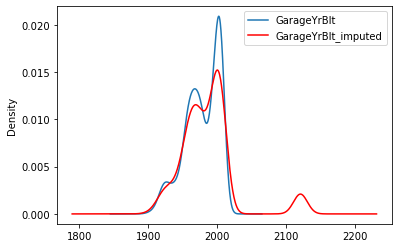

In [28]:
# for GarageYrBlt: 

# expected: the distribution has a small change

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['GarageYrBlt'].plot(kind='kde', ax=ax)

# imputed variable
X_train['GarageYrBlt_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

__B) a change in the variance:__

In [29]:
# for LotFrontAge: 

# expected: quite a bit as the percentage of missing data is quite
# high ~20%

print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after imputation: ', X_train['LotFrontage_imputed'].var())

Original Variance:  532.5872021885676
Variance after imputation:  1313.0936747097685


In [30]:
# for MasnVnrArea: 

# expected: tiny changes

print('Original Variance: ', X_train['MasVnrArea'].var())
print('Variance after imputation: ', X_train['MasVnrArea_imputed'].var())

Original Variance:  32983.538710039466
Variance after imputation:  34441.33126074531


In [31]:
# for GarageYrBlt: 

# expected: big change

print('Original Variance: ', X_train['GarageYrBlt'].var())
print('Variance after imputation: ', X_train['GarageYrBlt_imputed'].var())

Original Variance:  624.3059475074134
Variance after imputation:  1615.4973961677558


__C) a change in the covariance:__

In [32]:
X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_imputed,MasVnrArea_imputed,GarageYrBlt_imputed
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.934872e+02,-71.708328
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,3.425501,1.035991e+02,5.292881
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,639.100679,3.298354e+04,473.033527
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,-850.739199,7.680598e+03,1364.263017
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,2308.792907,2.473980e+04,725.046819
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,3142.724647,2.055453e+04,70.141209
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,3723.250100,3.541558e+04,20.700275
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,26.484608,1.274750e+03,624.305948
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,542.437312,3.088048e+03,189.382659
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,578446.035624,6.872641e+06,271654.954164


__D) a change in the outlier amount:__

<AxesSubplot:>

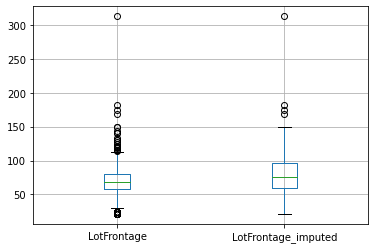

In [33]:
# for LotFrontAge: 

# fewer outliers as well after the imputation

X_train[['LotFrontage', 'LotFrontage_imputed']].boxplot()

<AxesSubplot:>

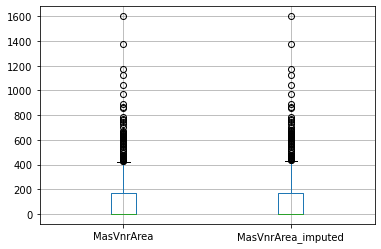

In [34]:
# for MasVnrArea: 

# the outliers are not so affected

X_train[['MasVnrArea', 'MasVnrArea_imputed']].boxplot()

<AxesSubplot:>

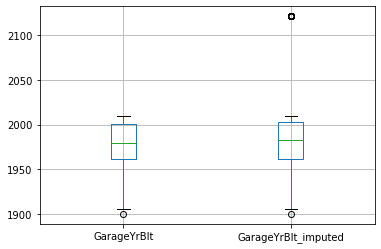

In [35]:
# for GarageYrBlt: 

# more outliers might be there as the max value before imp - 2010.0,
# imputed value - 2121.0

X_train[['GarageYrBlt', 'GarageYrBlt_imputed']].boxplot()

In [36]:
X_train.GarageYrBlt.max()

2010.0

In [37]:
X_train.GarageYrBlt_imputed.max()

2121.0